In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"

import jax.numpy as np
import matplotlib.pyplot as plt
from jax import random
from nrmifactors import algorithm as algo
from nrmifactors.state import State
import nrmifactors.priors as priors

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [2]:
ngroups = 5
ndata = 100

key = random.PRNGKey(0)

means = np.array([-10.0, 0.0, 10.0])

probas = np.vstack(
    [np.ones(3),
     np.array([0, 1, 0]),
     np.array([1, 0, 1]),
     np.array([0, 0, 1]),
     np.array([1, 0, 0])])


key, subkey = random.split(key)
clus = tfd.Categorical(probs=probas).sample((ndata), seed=subkey).T
data = tfd.Normal(means[clus], np.ones_like(clus, dtype=float)).sample(seed=subkey)

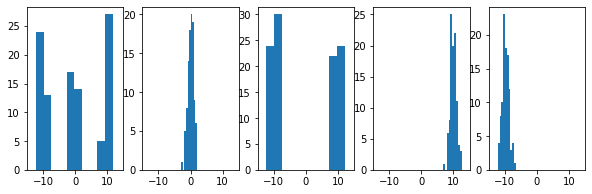

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=ngroups, figsize=(10, 3))
for i in range(ngroups):
    axes[i].hist(data[i, :])
    axes[i].set_xlim(-15, 15)

In [4]:
natoms = 10
nlat = 3

# initialize stuff
init_atoms = np.hstack([
    tfd.Normal(loc=0, scale=10).sample(natoms, seed=key).reshape(-1, 1),
    np.ones((natoms, 1)) * 3
])

# init_atoms = np.hstack([means.reshape(-1, 1), np.ones_like(means).reshape(-1, 1) * 1])

lam = np.ones((ngroups, nlat)).astype(float) * 0.5
m = np.ones((nlat, natoms)).astype(float) * 0.5
# m = np.array([
#    [1.0, 0.01, 0.01],
#    [0.01, 1.0, 0.01],
#    [0.01, 0.01, 1.0]])

j = np.ones(natoms).astype(float) * 0.5
u = np.ones(ngroups).astype(float)

clus = tfd.Categorical(probs=np.ones(natoms)/natoms).sample(data.shape, seed=key)
state = State(init_atoms, j, lam, m, clus, u)

In [5]:
prior = priors.NrmiFacPrior(
    kern_prior=priors.NNIGPrior(0, 0.001, 1, 1),
    lam_prior=priors.GammaPrior(1, 1),
    m_prior=priors.GammaPrior(1, 1),
    j_prior=priors.GammaPrior(1, 1))

In [6]:
from copy import deepcopy


states = [deepcopy(state)]
for i in range(1000):
    print("\r{0}/{1}".format(i+1, 1000), flush=True, end=" ")
    #print(state.m[1, 2])
    
    state, key = algo.run_one_step(state, data, prior, key)
    states.append(deepcopy(state))

1000/1000 

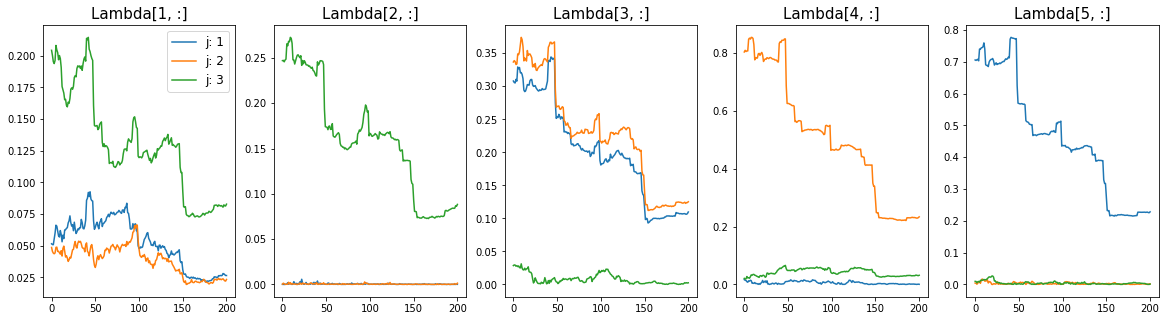

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i in range(ngroups):
    for j in range(nlat):
        axes[i].plot([x.lam[i, j] for x in states[800:]], label="j: {0}".format(j + 1))
    
    axes[i].set_title("Lambda[{0}, :]".format(i+1), fontsize=15)

axes[0].legend(fontsize=12)

#plt.savefig("prelimilary_simu/traceplot_lambda.pdf", bbox_inches="tight")


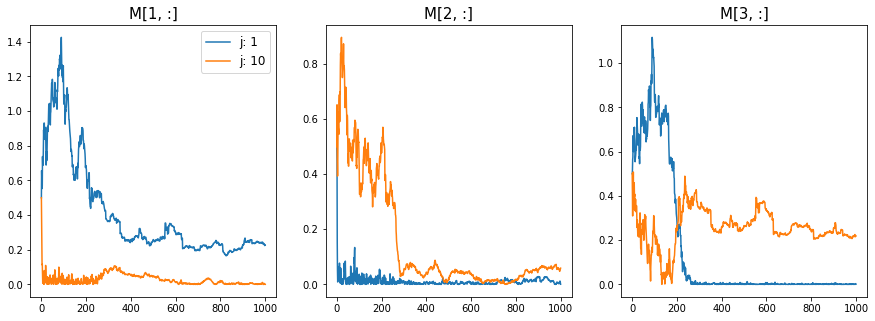

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i in range(nlat):
    axes[i].plot([x.m[i, 0] for x in states], label="j: {0}".format(1))
    axes[i].plot([x.m[i, 1] for x in states], label="j: {0}".format(10))
    axes[i].set_title("M[{0}, :]".format(i+1), fontsize=15)

axes[0].legend(fontsize=12)
# plt.savefig("prelimilary_simu/traceplot_m.pdf", bbox_inches="tight")
    

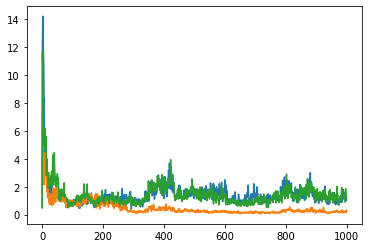

In [15]:
for j in range(3):
    plt.plot([x.j[j] for x in states], label="j: {0}".format(1))
    
# plt.savefig("prelimilary_simu/traceplot_j.pdf", bbox_inches="tight")
plt.show()

In [16]:
def eval_densities(xgrid, lam, m, j, atoms):
    weights = np.matmul(lam, m) * state.j
    weights /= weights.sum(axis=1)[:, np.newaxis]
    eval_comps = tfd.Normal(loc=atoms[:, 0], scale=np.sqrt(atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens = eval_comps[:, np.newaxis, :] * weights[np.newaxis, :, :]
    dens = np.sum(dens, axis=-1).T
    return dens

In [17]:
import pickle

#with open("prelimilary_simu/chains.pickle", "wb") as fp:
#    pickle.dump(states, fp)

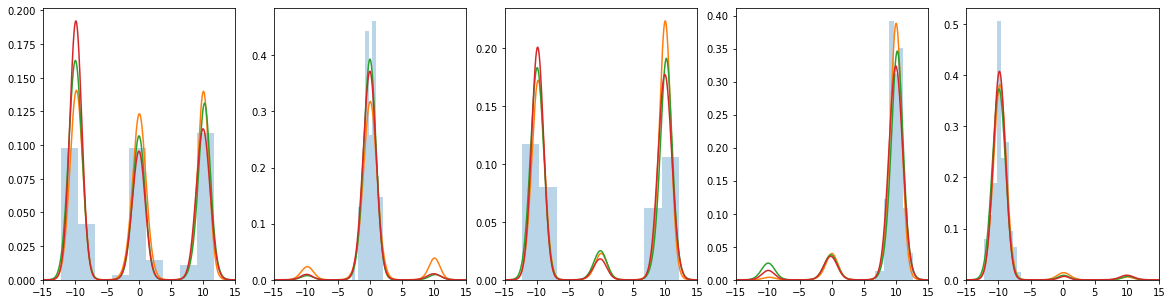

In [18]:
xgrid = np.linspace(-15, 15, 1000)

fig, axes = plt.subplots(nrows=1, ncols=ngroups, figsize=(20, 5))

idx = [-1, -100, -50]

for i in range(ngroups):
    axes[i].hist(data[i, :], density=True, alpha=0.3, bins="doane")

for j in idx:

    state = states[j]
    dens = eval_densities(xgrid, state.lam, state.m, state.j, state.atoms)
    for i in range(ngroups):
        axes[i].plot(xgrid, dens[i, :])
        axes[i].set_xlim(-15, 15)
        
#plt.savefig("prelimilary_simu/dens_estimate.pdf", bbox_inches="tight")        


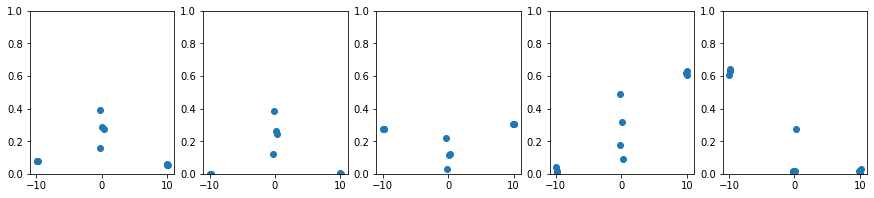

In [19]:
weights = np.matmul(state.lam, state.m) * state.j
weights /= np.sum(weights, axis=0)
fig, axes = plt.subplots(nrows=1, ncols=ngroups, figsize=(15, 3))


for i in range(ngroups):
    axes[i].scatter(state.atoms[:, 0], weights[i, :])
    axes[i].set_ylim(0, 1)
    

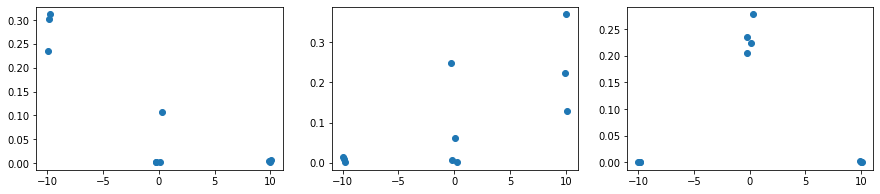

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=nlat, figsize=(15, 3))

for i in range(nlat):
    axes[i].scatter(state.atoms[:, 0], state.m[i, :])

In [ ]:
xgrid.shape

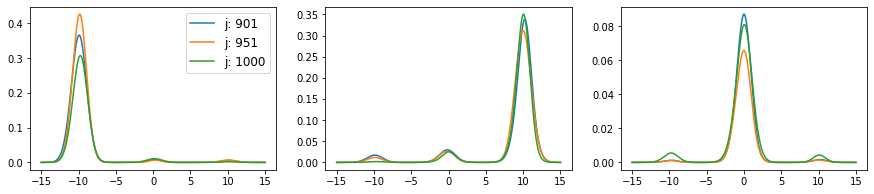

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=nlat, figsize=(15, 3))

for j in sorted(idx):
    state = states[j]

    eval_comps = tfd.Normal(
        loc=state.atoms[:, 0], scale=np.sqrt(state.atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens_lat = eval_comps[:, np.newaxis, :] * (state.m[np.newaxis, :, :] * state.j)
    dens_lat = np.sum(dens_lat, axis=-1).T    


    for i in range(nlat):
        axes[i].plot(xgrid, dens_lat[i, :], label="j: {0}".format(len(states) + j))
        
axes[0].legend(fontsize=12)
# plt.savefig("latent_dens.pdf", bbox_inches="tight")